1. Use dropout = 0.2

2. Add artificial features (air temp^2, abs hum^2, air temp * abs hum) 
    - Use regularization to reduce complexity

3. Plotting actual vs predicted using all data (fit NN to all data first)

In [242]:
# Function to split same percent for each unique data in df column
def split_unique(dataset, column, test_size):
  X_train2 = pd.DataFrame()
  X_test2 = pd.DataFrame()
  y_train2 = pd.DataFrame()
  y_test2 = pd.DataFrame()
  for i,C in enumerate(dataset[column].unique()):
    X = dataset[dataset[column] == C][['bldgname',
                                    'Air Temp', 
                                    'Abs Hum',
                                    'DSW Top', 
                                    'DSW North', 
                                    'DSW South', 
                                    'DSW East', 
                                    'DSW West', 
                                    'Shade North', 
                                    'Shade East', 
                                    'Shade West',
                                    'Shade South']]
    y = dataset[dataset[column] == C]['CHWTON/SQFT']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20)
    X_train2 = X_train2.append(X_train)
    X_test2 = X_test2.append(X_test)
    y_train2 = y_train2.append(y_train)
    y_test2 = y_test2.append(y_test)
  return X_train2, X_test2, y_train2, y_test2

# Split microclimate data 20% from each building for testing
split_unique(MicroclimateData, 'bldgname', 0.2)

# Check number of points in each building
# Note: Biodesign C has less data than all other buildings in original data
for i,C in enumerate(MicroclimateData['bldgname'].unique()):
  print(C, ":", len(MicroclimateData[MicroclimateData['bldgname']==C]))

Noble Library : 894
Biodesign C : 640
Biodesign A : 896
Schwada COB : 896
Psychology : 894
Goldwater : 895
ISTB 2 : 895
Bulldog Hall : 894
ISTB 4 : 895
Psychology North : 894
Biodesign B : 896


## Flow of Code:
#### 1. Read both datasets, and do data preparation: Scaling, One-hot Encoding
#### 2. For limited data, train  model on Temp, Hum, Dsw(4), Shade(4), Encoding input features (find hyperparameters analytically)
#### 3. For big data, train model on Temp, Hum, Encoding 
#### 4. Fine tune weather station model on microclimate data and compare performance
#### 5. Work on adding artificial features and dropout on microclimate model

In [1]:
# Load the TensorBoard notebook extension.

%reload_ext tensorboard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns
import tensorboard
tensorboard.__version__

'2.6.0'

In [243]:
class NeuralNetwork():
    def __init__(self,activation_type, hidden_layers, loss, kernel_initializer, bias_initializer, data_type,epochs):
        self.activation_type = activation_type
        self.hidden_layers = hidden_layers
        self.loss = loss
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer 
        self.data_type = data_type
        self.epochs = epochs

    def huber_loss(y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = tf.keras.backend.abs(error) < clip_delta
        squared_loss = 0.5 * tf.keras.backend.square(error)
        linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
        return tf.where(cond, squared_loss, linear_loss)
        
    def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
        return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))
        
    def prepare_data(self, dataset, func):
        Y = MicroclimateData['CHWTON/SQFT']
        Y = Y.values.reshape(-1, 1)
        StdSc1 = StandardScaler()
        Y = StdSc1.fit_transform(Y)
        if self.data_type == 'WeatherStation'  and (func == 'test' or func == 'train'):
            X = dataset[['bldgname','Air Temp', 'Abs Hum']]
            columns = ['Air Temp', 'Abs Hum']
        if self.data_type == 'Microclimate' and func == 'train':
            X = MicroclimateData[['bldgname',
                                  'Air Temp', 
                                  'Abs Hum',
                                  'DSW Top', 
                                  'DSW North', 
                                  'DSW South', 
                                  'DSW East', 
                                  'DSW West', 
                                  'Shade North', 
                                  'Shade East', 
                                  'Shade West',
                                  'Shade South']]
            columns = ['Air Temp', 'Abs Hum', 'DSW Top', 'DSW North', 
                       'DSW South', 'DSW East','DSW West', 'Shade North', 
                       'Shade East', 'Shade West', 'Shade South',]
        if self.data_type == 'Microclimate' and func == 'test':
            X = dataset[['bldgname','Air Temp','Abs Hum']]
            columns = ['Air Temp', 'Abs Hum']
        X = pd.get_dummies(X)
        StdSc2 = StandardScaler()
        X[columns] = StdSc2.fit_transform(X[columns])
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=0.2, 
                                                            random_state=20)
        return X_train, X_test, y_train, y_test
    def define_model(self):
        if self.data_type == 'WeatherStation' :
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(20, 
                                input_dim=13, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(30, activation = self.activation_type))
                model.add(Dense(20, activation = self.activation_type))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=13, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(20, activation = self.activation_type))
                model.add(Dense(1, activation = 'linear'))
            
            
        if self.data_type == 'Microclimate':
            model = Sequential()
            if self.activation_type == 'leaky_relu':
                model.add(Dense(30, 
                                input_dim=22, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(20, activation = self.activation_type))
                model.add(Dense(1, activation = 'linear'))
            else:
                model.add(Dense(30, 
                                input_dim=22, 
                                kernel_initializer=self.kernel_initializer, 
                                bias_initializer=self.bias_initializer, 
                                activation= self.activation_type))
                for i in range(0,(self.hidden_layers-2)):
                    model.add(Dense(40, activation = self.activation_type))
                model.add(Dense(20, activation = self.activation_type))
                model.add(Dense(1, activation = 'linear'))
        model.compile( loss = self.loss, 
                      optimizer = 'adam')
        model.summary()
        return model
    def train(self, dataset):
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'train')
        self.model = self.define_model()
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
    def fine_tune(self, dataset):
        self.model.trainable = True
        fine_tune_at = 2
        for layer in self.model.layers[:fine_tune_at]:
            layer.trainable =  False
        self.model.compile(loss=self.loss, 
                           optimizer='adam')
        X_train, X_test, y_train, y_test = self.prepare_data(dataset,'test')
        # Define the Keras TensorBoard callback.
        logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        self.history = self.model.fit(X_train,y_train, 
                            batch_size=128, 
                            epochs=self.epochs, 
                            verbose=0, 
                            validation_split=0.2, 
                            callbacks=[tensorboard_callback])
        
        
    def plot_curve(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    def evaluate(self, dataset, data_type ):
        call_type = 'test'
        if data_type == self.data_type:
            call_type = 'train'
        _, X_test, _, y_test = self.prepare_data(dataset,call_type)
        Y_preds = self.model.predict(X_test)
        RMSE = np.sqrt(metrics.mean_squared_error(y_test, Y_preds))
        R2_score = metrics.r2_score(y_test, Y_preds)
        print("The RMSE score for test dataset of "+ data_type +" is:", RMSE)
        print("The R2 score for test dataset of "+ data_type +" is:", R2_score)
        return Y_preds, y_test, X_test 

In [244]:
MicroclimateData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/all_buildings_limited.csv')
WeatherStationData = pd.read_csv('/content/drive/Shareddrives/Microclimate-Building Energy/Data/NN_big_data/Combined/all_buildings_big.csv')
if __name__ == "__main__":
    # Train microclimate Model
    MicroclimateModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'Microclimate', 200)
    MicroclimateModel.train(MicroclimateData)
    Y_preds, y_test, X_test = MicroclimateModel.evaluate(MicroclimateData, 'Microclimate')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 30)                690       
_________________________________________________________________
dense_91 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_92 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_93 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 21        
Total params: 4,411
Trainable params: 4,411
Non-trainable params: 0
_________________________________________________________________
The RMSE score for test dataset of Microclimate is: 0.13636620050656614
The R2 score for test dataset of Microclimate

Use this to return dummy variables to original columns example: df2 = undummify(df2) 

In [ ]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

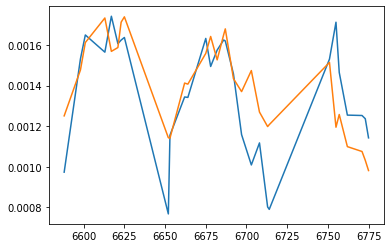

In [144]:
# Sample of how plotting can be performed, need to do this by day
time = MicroclimateData[['Date_Time','Month','Day','Hour','Minute']]
results = undummify(X_test)
col = results.pop('bldgname')
results.insert(0, 'bldgname', col)
results['Actual'] = StdSc1.inverse_transform(y_test)
results['Predicted'] = StdSc1.inverse_transform(Y_preds)
results[results['bldgname'] == 'Bulldog Hall']
results = results.join(time)
bldg = results[results['bldgname']=='Bulldog Hall']
month = bldg[bldg['Month'] == 8]
z = month.sort_values(by=['Month', 'Day', 'Hour', 'Minute'])
plt.plot(z['Actual'])
plt.plot(z['Predicted'])
plt.show()

In [146]:
X_test

,Air Temp,Abs Hum,DSW Top,DSW North,DSW South,DSW East,DSW West,Shade North,Shade East,Shade West,Shade South,bldgname_Biodesign A,bldgname_Biodesign B,bldgname_Biodesign C,bldgname_Bulldog Hall,bldgname_Goldwater,bldgname_ISTB 2,bldgname_ISTB 4,bldgname_Noble Library,bldgname_Psychology,bldgname_Psychology North,bldgname_Schwada COB
6775,0.275443,-0.186465,-1.287412,-0.487994,-0.702624,-0.649227,-0.637664,0.553371,0.701577,0.710544,0.930102,0,0,0,1,0,0,0,0,0,0,0
5612,1.235027,-0.805584,-0.261557,3.568272,-0.702624,-0.649227,0.064431,-3.038733,0.701577,0.198545,0.930102,0,0,0,0,0,1,0,0,0,0,0
5922,0.798287,0.264034,0.510724,-0.487994,2.518017,-0.649227,1.302011,0.553371,0.701577,-0.689696,-1.431988,0,0,0,0,0,1,0,0,0,0,0
5293,0.567240,-1.102149,-0.564272,4.191468,-0.702624,-0.649227,0.019229,-3.038733,0.701577,0.206558,0.930102,0,0,0,0,0,1,0,0,0,0,0
1910,1.000088,-0.757436,-1.114901,1.883767,-0.702624,-0.649227,0.242471,-1.122683,0.701577,-0.296867,0.930102,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7845,-0.125959,-1.155272,0.188304,-0.391257,-0.702624,-0.649227,1.207942,-2.004350,0.701577,-0.428438,0.930102,0,0,0,0,0,0,0,0,0,1,0
2222,1.391057,1.137430,-0.124355,-0.207785,-0.702624,-0.649227,1.889994,-1.677883,0.701577,-1.062655,0.930102,1,0,0,0,0,0,0,0,0,0,0
5696,-0.453844,2.597128,-1.219543,0.713460,-0.702624,-0.045644,-0.637664,-3.133262,-1.279160,0.710544,0.930102,0,0,0,0,0,1,0,0,0,0,0
2168,1.252946,1.492194,-1.287412,-0.487994,-0.702624,-0.649227,-0.637664,0.553371,0.701577,0.710544,0.930102,1,0,0,0,0,0,0,0,0,0,0


In [145]:
z

,bldgname,Air Temp,Abs Hum,DSW Top,DSW North,DSW South,DSW East,DSW West,Shade North,Shade East,Shade West,Shade South,Actual,Predicted,Date_Time,Month,Day,Hour,Minute
6588,Bulldog Hall,-0.669850,2.768201,-1.287412,-0.487994,-0.702624,-0.649227,-0.637664,0.553371,0.701577,0.710544,0.930102,0.000974,0.001251,2018-08-01 06:00:00,8,1,6,0
6598,Bulldog Hall,-0.125118,2.954782,-0.088388,-0.469803,-0.702624,1.636485,-0.637664,-0.218877,-1.302809,0.710544,0.930102,0.001531,0.001477,2018-08-01 08:30:00,8,1,8,30
6601,Bulldog Hall,0.209971,3.150610,0.296398,-0.487994,-0.209035,1.587558,-0.637664,0.553371,-1.266381,0.710544,-0.992479,0.001649,0.001612,2018-08-01 09:15:00,8,1,9,15
6613,Bulldog Hall,1.204757,2.240515,1.274052,-0.487994,1.678575,-0.282397,-0.637664,0.553371,-1.327937,0.710544,-1.474161,0.001564,0.001732,2018-08-01 12:15:00,8,1,12,15
6617,Bulldog Hall,1.439082,1.943215,1.264885,-0.487994,1.657734,-0.649227,0.122184,0.553371,0.701577,-2.214495,-1.473393,0.001741,0.001568,2018-08-01 13:15:00,8,1,13,15
6621,Bulldog Hall,1.588440,1.757362,1.076657,-0.487994,1.213677,-0.649227,1.227769,0.553371,0.701577,-2.020369,-1.402898,0.001606,0.001587,2018-08-01 14:15:00,8,1,14,15
6623,Bulldog Hall,1.642124,1.706376,0.914719,-0.487994,0.946847,-0.649227,1.675810,0.553371,0.701577,-1.931393,-1.431858,0.001624,0.001712,2018-08-01 14:45:00,8,1,14,45
6625,Bulldog Hall,1.685381,1.651023,0.723482,-0.487994,0.555027,-0.649227,2.028798,0.553371,0.701577,-1.858224,-1.390950,0.001636,0.001738,2018-08-01 15:15:00,8,1,15,15
6652,Bulldog Hall,-0.947645,2.143868,-1.287412,-0.487994,-0.702624,-0.649227,-0.637664,0.553371,0.701577,0.710544,0.930102,0.000768,0.001143,2018-08-03 06:00:00,8,3,6,0
6653,Bulldog Hall,-0.938194,2.135278,-1.287412,-0.487994,-0.702624,-0.649227,-0.637664,0.553371,0.701577,0.710544,0.930102,0.001155,0.001141,2018-08-03 06:15:00,8,3,6,15


In [16]:
# Train Weather Station Model
WeatherStationModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
WeatherStationModel.train(WeatherStationData)
WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 30)                420       
_________________________________________________________________
dense_26 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_27 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_28 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 21        
Total params: 4,141
Trainable params: 4,141
Non-trainable params: 0
_________________________________________________________________
The RMSE score for test dataset of WeatherStationis: 0.49311557
The R2 score for test dataset of WeatherStationis: 0.7

In [6]:
# Train Weather Station Model
WeatherStationModel = NeuralNetwork('relu',4, 'huber_loss', 'he_normal','he_normal', 'WeatherStation', 100)
WeatherStationModel.train(WeatherStationData)
WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 4,141
Trainable params: 4,141
Non-trainable params: 0
_________________________________________________________________
The RMSE score for test dataset of Microclimateis: 0.5000325
The R2 score for test dataset of Microclimateis: 0.741961

In [7]:
# Fine Tune and compare results
WeatherStationModel.fine_tune(MicroclimateData)
WeatherStationModel.evaluate(MicroclimateData, 'Microclimate')
WeatherStationModel.evaluate(WeatherStationData, 'WeatherStation')

The RMSE score for test dataset of Microclimateis: 0.1534751
The R2 score for test dataset of Microclimateis: 0.9756911648837542
The RMSE score for test dataset of WeatherStationis: 0.5176528
The R2 score for test dataset of WeatherStationis: 0.7320702629528133


In [9]:
WeatherStationModel.prepare_data(MicroclimateData, 'test')

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.8847117 ,  0.04124958],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.82558256, -0.87358415],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.6573643 , -1.2165139 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.29551396, -0.9936511 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.0540725 , -0.65212667],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.54206187, -0.6222965 ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.2754427 , -0.18646547],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.2350274 , -0.80558413],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.7982873 ,  0.26403353],
        ...,
        [ 0.        ,  0.        ,  0. 